# Boston Housing

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit


# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('/home/krupal/Downloads/housing.csv')

#Data preprocessing
data = data.drop(data[(data['MEDV'] == 50.0)].index, axis = 0)
data = data.drop(data[(data['RM'] == 8.78)].index, axis = 0)
data = data.drop(['INDUS','CHAS','NOX','DIS','RAD','TAX'], axis = 1)
#Values in the 'MEDV' column are multiple of hundreds
data['MEDV'] = data['MEDV']*1000
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# Success
print("Boston housing dataset has {} data points with {} variables each.".format(*data.shape))

Boston housing dataset has 489 data points with 8 variables each.


In [3]:
# Minimum price of the data
minimum_price = prices.min()

# Maximum price of the data
maximum_price = prices.max()

# Mean price of the data
mean_price = prices.mean()

# Median price of the data
median_price = prices.median()

# Standard deviation of prices of the data
std_price = prices.std()

print("Statistics for Boston housing dataset:\n")
print("Minimum price: ${}".format(minimum_price)) 
print("Maximum price: ${}".format(maximum_price))
print("Mean price: ${}".format(mean_price))
print("Median price ${}".format(median_price))
print("Standard deviation of prices: ${}".format(std_price))

Statistics for Boston housing dataset:

Minimum price: $5000.0
Maximum price: $48800.0
Mean price: $21635.378323108383
Median price $20900.0
Standard deviation of prices: $7873.346554888944


In [4]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """

    score = r2_score(y_true,y_predict)
    
    # Return the score
    return score


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, prices, random_state = 0, test_size = 0.2)

print("Training and testing split was successful.")

Training and testing split was successful.


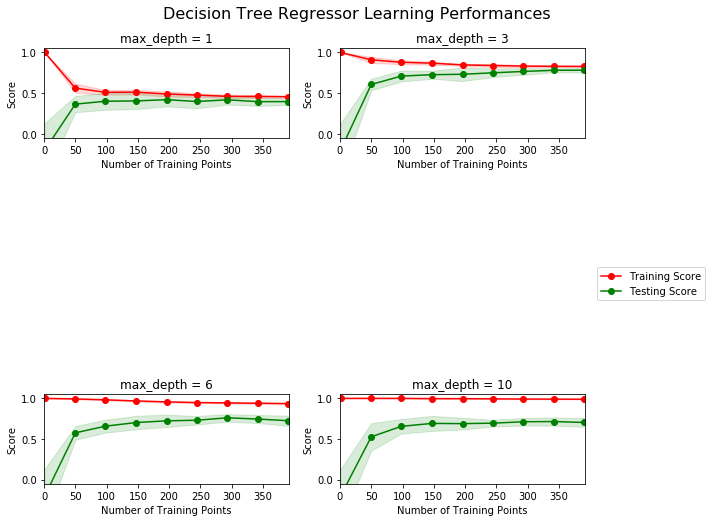

In [5]:
import matplotlib.pyplot as pl
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeRegressor


def ModelLearning(X, y):
    """ Calculates the performance of several models with varying sizes of training data.
        The learning and testing scores for each model are then plotted. """

    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

    # Generate the training set sizes increasing by 50
    train_sizes = np.rint(np.linspace(1, X.shape[0]*0.8 - 1, 9)).astype(int)

    # Create the figure window
    fig = pl.figure(figsize=(10,7))

    # Create three different models based on max_depth
    for k, depth in enumerate([1,3,6,10]):

        # Create a Decision tree regressor at max_depth = depth
        regressor = DecisionTreeRegressor(max_depth = depth)

        # Calculate the training and testing scores
        sizes, train_scores, test_scores = learning_curve(regressor, X, y, \
            cv = cv, train_sizes = train_sizes, scoring = 'r2')

        # Find the mean and standard deviation for smoothing
        train_std = np.std(train_scores, axis = 1)
        train_mean = np.mean(train_scores, axis = 1)
        test_std = np.std(test_scores, axis = 1)
        test_mean = np.mean(test_scores, axis = 1)

        # Subplot the learning curve
        ax = fig.add_subplot(2, 2, k+1)
        ax.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
        ax.plot(sizes, test_mean, 'o-', color = 'g', label = 'Testing Score')
        ax.fill_between(sizes, train_mean - train_std, \
            train_mean + train_std, alpha = 0.15, color = 'r')
        ax.fill_between(sizes, test_mean - test_std, \
            test_mean + test_std, alpha = 0.15, color = 'g')

        # Labels
        ax.set_title('max_depth = %s'%(depth))
        ax.set_xlabel('Number of Training Points')
        ax.set_ylabel('Score')
        ax.set_xlim([0, X.shape[0]*0.8])
        ax.set_ylim([-0.05, 1.05])

    # Visual aesthetics
    ax.legend(bbox_to_anchor=(1.05, 2.05), loc='lower left', borderaxespad = 0.)
    fig.suptitle('Decision Tree Regressor Learning Performances', fontsize = 16, y = 1.03)
    fig.tight_layout()
    fig.show()

    
ModelLearning(features, prices)

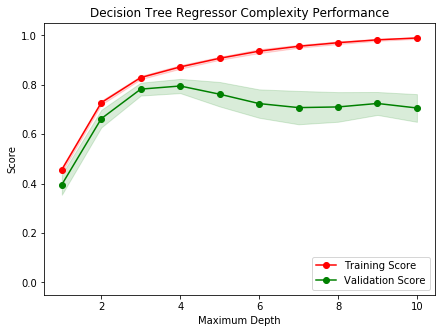

In [26]:
def ModelComplexity(X, y):
    """ Calculates the performance of the model as model complexity increases.
        The learning and testing errors rates are then plotted. """

    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

    # Vary the max_depth parameter from 1 to 10
    max_depth = np.arange(1,11)

    # Calculate the training and testing scores
    train_scores, test_scores = validation_curve(DecisionTreeRegressor(), X, y, \
        param_name = "max_depth", param_range = max_depth, cv = cv, scoring = 'r2')

    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    pl.figure(figsize=(7, 5))
    pl.title('Decision Tree Regressor Complexity Performance')
    pl.plot(max_depth, train_mean, 'o-', color = 'r', label = 'Training Score')
    pl.plot(max_depth, test_mean, 'o-', color = 'g', label = 'Validation Score')
    pl.fill_between(max_depth, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    pl.fill_between(max_depth, test_mean - test_std, \
        test_mean + test_std, alpha = 0.15, color = 'g')

    # Visual aesthetics
    pl.legend(loc = 'lower right')
    pl.xlabel('Maximum Depth')
    pl.ylabel('Score')
    pl.ylim([-0.05,1.05])
    pl.show()

    
ModelComplexity(features, prices)

In [6]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """

    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0)

    regressor = DecisionTreeRegressor()
    regressor_fit = regressor.fit(X,y)

    params = {'max_depth' : range(1,11)}
 
    scoring_fnc = make_scorer(performance_metric)

    grid = GridSearchCV(regressor,params,scoring_fnc,cv=cv_sets)

    grid = grid.fit(X, y)

    return grid.best_estimator_


# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))

Parameter 'max_depth' is 4 for the optimal model.


In [15]:
#Predicting for the first 3 clients in the test set
price_prediction = reg.predict(X_test)
for i in range(3):
    price = price_prediction[i]
    print("Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price))

Predicted selling price for Client 1's home: $20,765.00
Predicted selling price for Client 2's home: $30,640.74
Predicted selling price for Client 3's home: $16,066.67


In [25]:
#Accuracy of the model
from sklearn.metrics import accuracy_score
score = r2_score(np.array(y_test),price_prediction)
print("The accuracy of the model in terms of r2_score metric is: ",score)

The accuracy of the model in terms of r2_score metric is:  0.758845357352
